<a href="https://colab.research.google.com/github/ashlearo/ML/blob/main/3_%D0%B2%D1%8B%D0%B1%D0%BE%D1%80%D0%BA%D0%B8_%D0%B4%D0%B8%D0%BF%D0%BB%D0%BE%D0%BC_%D0%BE%D0%BA%D0%BE%D0%BD%D1%87%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F_%D0%B2%D0%B5%D1%80%D1%81%D0%B8%D1%8F_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install catboost shap

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy import stats
from sklearn.impute import SimpleImputer
import random
import time
import datetime
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import sys
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from collections import Counter
import catboost as cb
import time
import datetime
import shap
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
shap.initjs()
from sklearn.metrics import recall_score
from sklearn.feature_selection import RFECV
from catboost import CatBoostClassifier



In [ ]:
data_raw = pd.read_csv('marketing_data.csv')

Приведем в порядок названия колонок, удалим лишний значок доллара, переведем дату в корректный формат.

In [ ]:
data_raw.rename(columns={' Income ' : 'Income'}, inplace=True)
data_raw.rename(columns={'Dt_Customer' : 'Enroll_date'}, inplace=True)

In [ ]:
data_raw['Income'] = data_raw['Income'].replace("[$,]", "", regex=True).astype(float)

In [ ]:
data_raw['Enroll_date'] = pd.to_datetime(data_raw['Enroll_date'])

In [ ]:
data_raw

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country,CmpTotal_mean_2,CmpTotal_mean_3,CmpTotal_mean_4,CmpTotal_mean_5,Time_delta
0,1826,1970,Graduation,Divorced,84835.0,0,0,0,189,104,379,111,189,218,1,4,4,6,1,0,0,0,0,0,1,0,SP,0.0,0.000000,0.00,0.0,13
1,1,1961,Graduation,Single,57091.0,0,0,0,464,5,64,7,0,37,1,7,3,7,5,0,0,0,0,1,1,0,CA,0.5,0.333333,0.25,0.2,14
2,10476,1958,Graduation,Married,67267.0,0,1,0,134,11,59,15,2,30,1,3,2,5,2,0,0,0,0,0,0,0,US,0.0,0.000000,0.00,0.0,47
3,1386,1967,Graduation,Together,32474.0,1,1,0,10,0,1,0,0,0,1,1,0,2,7,0,0,0,0,0,0,0,AUS,0.0,0.000000,0.00,0.0,49
4,5371,1989,Graduation,Single,21474.0,1,0,0,6,16,24,11,0,34,2,3,1,2,7,1,0,0,0,0,1,0,SP,0.0,0.333333,0.25,0.2,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10142,1976,PhD,Divorced,66476.0,0,1,99,372,18,126,47,48,78,2,5,2,11,4,0,0,0,0,0,0,0,US,0.0,0.000000,0.00,0.0,479
2236,5263,1977,2n Cycle,Married,31056.0,1,0,99,5,10,13,3,8,16,1,1,0,3,8,0,0,0,0,0,0,0,SP,0.0,0.000000,0.00,0.0,523
2237,22,1976,Graduation,Divorced,46310.0,1,0,99,185,2,88,15,5,14,2,6,1,5,8,0,0,0,0,0,0,0,SP,0.0,0.000000,0.00,0.0,573
2238,528,1978,Graduation,Married,65819.0,0,0,99,267,38,701,149,165,63,1,5,4,10,3,0,0,0,0,0,0,0,IND,0.0,0.000000,0.00,0.0,577


Посмотрим статистику и описание данных - пропусков нет, числовые данные достаточно разнородны.

In [ ]:
data_raw.nunique()

ID                     2240
Year_Birth               59
Education                 5
Marital_Status            8
Income                 1974
Kidhome                   3
Teenhome                  3
Enroll_date             663
Recency                 100
MntWines                776
MntFruits               158
MntMeatProducts         558
MntFishProducts         182
MntSweetProducts        177
MntGoldProds            213
NumDealsPurchases        15
NumWebPurchases          15
NumCatalogPurchases      14
NumStorePurchases        14
NumWebVisitsMonth        16
AcceptedCmp3              2
AcceptedCmp4              2
AcceptedCmp5              2
AcceptedCmp1              2
AcceptedCmp2              2
Response                  2
Complain                  2
Country                   8
dtype: int64

In [ ]:
data_raw.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.149107,0.009375
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.356274,0.096391
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2240 non-null   int64         
 1   Year_Birth           2240 non-null   int64         
 2   Education            2240 non-null   object        
 3   Marital_Status       2240 non-null   object        
 4   Income               2216 non-null   float64       
 5   Kidhome              2240 non-null   int64         
 6   Teenhome             2240 non-null   int64         
 7   Enroll_date          2240 non-null   datetime64[ns]
 8   Recency              2240 non-null   int64         
 9   MntWines             2240 non-null   int64         
 10  MntFruits            2240 non-null   int64         
 11  MntMeatProducts      2240 non-null   int64         
 12  MntFishProducts      2240 non-null   int64         
 13  MntSweetProducts     2240 non-nul

Создадим новые фичи - среднее значение по участию в акциях за различные периоды, добавим значение лояльности человека в месяцах.

In [ ]:
data_raw['CmpTotal_mean_2'] = (data_raw['AcceptedCmp1']+data_raw['AcceptedCmp2'])/2
data_raw['CmpTotal_mean_3'] = (data_raw['AcceptedCmp1']+data_raw['AcceptedCmp2']+data_raw['AcceptedCmp3'])/3
data_raw['CmpTotal_mean_4'] = (data_raw['AcceptedCmp1']+data_raw['AcceptedCmp2']+data_raw['AcceptedCmp3']+data_raw['AcceptedCmp4'])/4
data_raw['CmpTotal_mean_5'] = (data_raw['AcceptedCmp1']+data_raw['AcceptedCmp2']+data_raw['AcceptedCmp3']+data_raw['AcceptedCmp4']+data_raw['AcceptedCmp5'])/5

In [ ]:
data_raw['Enroll_date'] = pd.to_datetime(data_raw['Enroll_date'])
data_raw['Time_delta'] = data_raw.Enroll_date.max() - data_raw.Enroll_date
data_raw['Time_delta'] = data_raw['Time_delta'].dt.days

In [ ]:
data_raw = data_raw.drop(columns=['Enroll_date'])

Посмотрим на корреляцию, наша ключевая переменная Response имеет слабую корреляцию с другими признаками.

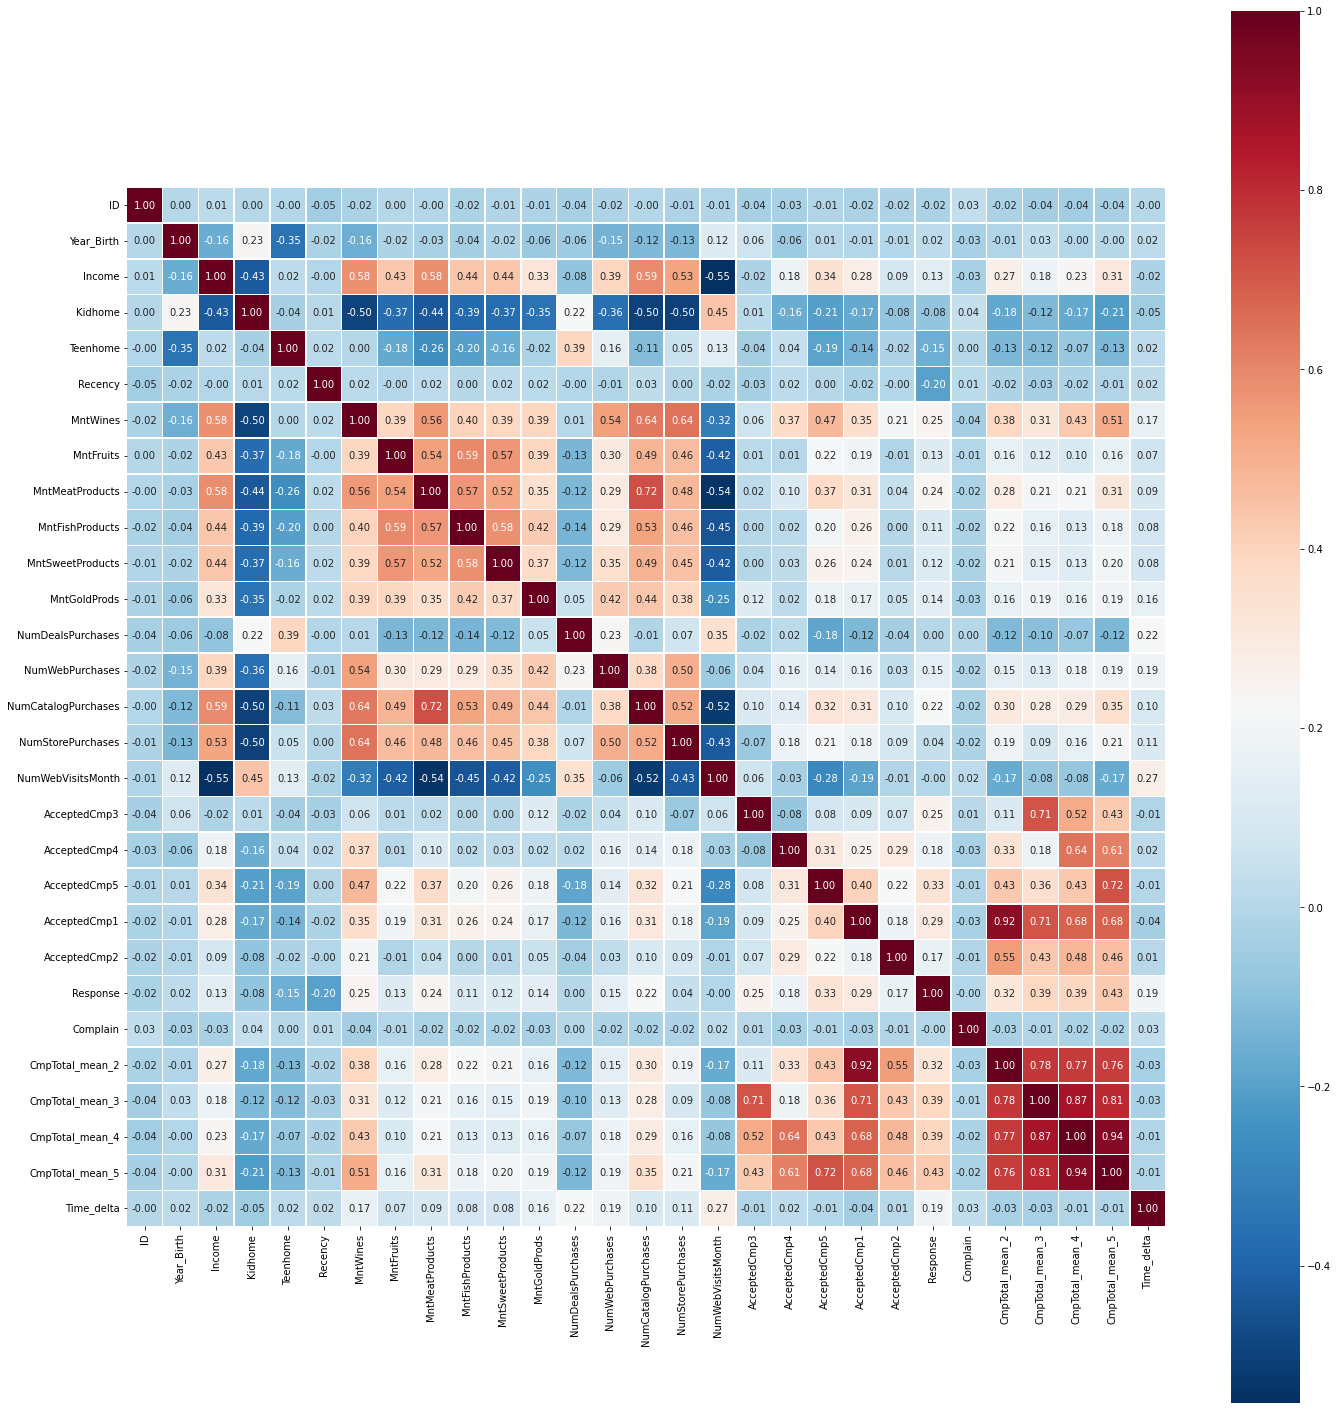

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(data_raw._get_numeric_data().astype(float).corr(),
            square=True, cmap='RdBu_r', linewidths=.5,
            annot=True, fmt='.2f').figure.tight_layout()
plt.show()

Посмотрим на категориальные признаки - образование, семейный статус, страна проживания. Больше всего людей имеют высшее образование, женаты, проживают в Испании.

In [ ]:
category_features = data_raw.select_dtypes(include=['object']).columns.values

for col in category_features:
    print(col, "(", len(data_raw[col].unique()) , "values):\n", data_raw[col].unique())

Education ( 5 values):
 ['Graduation' 'PhD' '2n Cycle' 'Master' 'Basic']
Marital_Status ( 8 values):
 ['Divorced' 'Single' 'Married' 'Together' 'Widow' 'YOLO' 'Alone' 'Absurd']
Country ( 8 values):
 ['SP' 'CA' 'US' 'AUS' 'GER' 'IND' 'SA' 'ME']


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


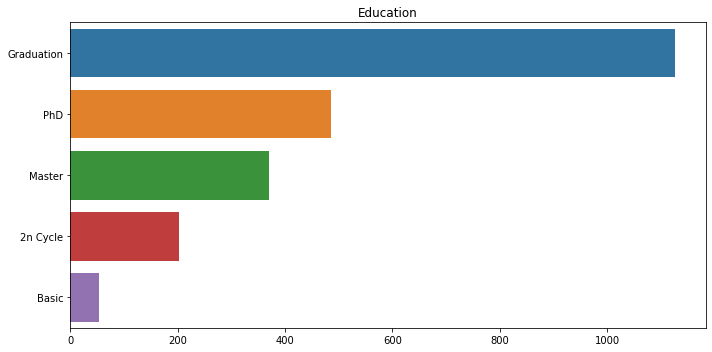

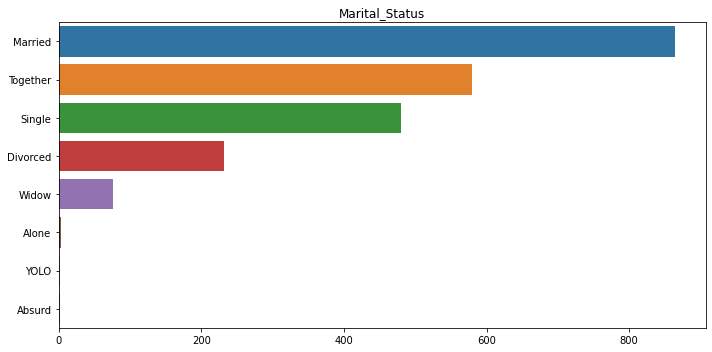

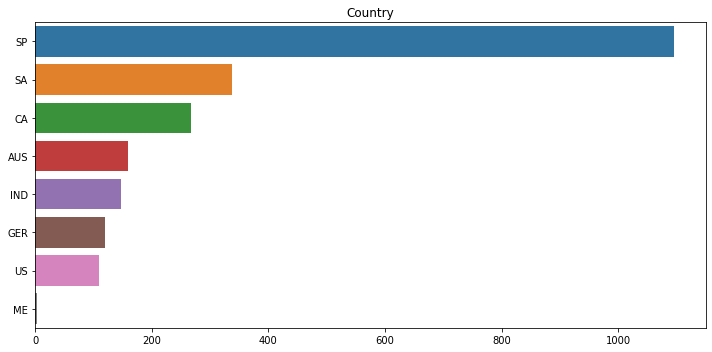

In [ ]:
for col in category_features:
    plt.figure(figsize=(10,5))
    sns.barplot(data_raw[col].value_counts().values, data_raw[col].value_counts().index, data=data_raw)
    plt.title(col)
    plt.tight_layout()


Разделим наш датасет на тренинговую, валидационную и тестовую выборку, информацию о последней акции возьмем, как ключевое значение. Размер тестовой и валидационной выборок равен 20% от тренинговой каждая.

In [ ]:
y = data_raw['Response']
X = data_raw.drop(columns=['Response'])

X_temp, X_test, y_temp, y_test, = train_test_split(X, y, test_size = 0.15, random_state=2)

print("Number transactions X_temp dataset: ", X_temp.shape)
print("Number transactions y_temp dataset: ", y_temp.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_temp dataset:  (1904, 31)
Number transactions y_temp dataset:  (1904,)
Number transactions X_test dataset:  (336, 31)
Number transactions y_test dataset:  (336,)


In [ ]:
X_train, X_val, y_train, y_val, = train_test_split(X_temp, y_temp, test_size = 0.175, random_state=2)
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_val dataset: ", X_val.shape)
print("Number transactions y_val dataset: ", y_val.shape)

Number transactions X_train dataset:  (1570, 31)
Number transactions y_train dataset:  (1570,)
Number transactions X_val dataset:  (334, 31)
Number transactions y_val dataset:  (334,)


In [ ]:
y_base = np.where(y_test==0, 1, y_test)
y_base[0] = 0

Проверим валидность выборок.

In [ ]:
print(y_train.mean(), y_val.mean(), y_test.mean())

0.15796178343949044 0.11676646706586827 0.13988095238095238


Создадим списки с категориальными и числовыми фичами.

In [ ]:
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns.values

category_features = X_train.select_dtypes(include=['object']).columns.values

print(numeric_features)
print(category_features)

['ID' 'Year_Birth' 'Income' 'Kidhome' 'Teenhome' 'Recency' 'MntWines'
 'MntFruits' 'MntMeatProducts' 'MntFishProducts' 'MntSweetProducts'
 'MntGoldProds' 'NumDealsPurchases' 'NumWebPurchases'
 'NumCatalogPurchases' 'NumStorePurchases' 'NumWebVisitsMonth'
 'AcceptedCmp3' 'AcceptedCmp4' 'AcceptedCmp5' 'AcceptedCmp1'
 'AcceptedCmp2' 'Complain' 'CmpTotal_mean_2' 'CmpTotal_mean_3'
 'CmpTotal_mean_4' 'CmpTotal_mean_5' 'Time_delta']
['Education' 'Marital_Status' 'Country']


Создадим функцию one hot encoding для замены категориальных значений путем создания новых колонок типа "вид образования (Graduation)" 0 или 1 (пример).

In [ ]:
def dummify(ohe, x, columns):
    transformed_array = ohe.transform(x)

    # list of category columns
    enc = ohe.named_transformers_['cat'].named_steps['onehot']
    feature_lst = enc.get_feature_names_out(category_features.tolist())

    cat_colnames = np.concatenate([feature_lst]).tolist()
    all_colnames = numeric_features.tolist() + cat_colnames

    # convert numpy array to dataframe
    df = pd.DataFrame(transformed_array, index = x.index, columns = all_colnames)

    return transformed_array, df

Преобразовываем данные в стандартное нормальное распределение с помощью StandardScaler.

In [ ]:
# impute missing numerical values with a median value, then scale the values
numeric_transformer = Pipeline(steps=[
   ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# impute missing categorical values using the 'missing' and one hot encode the categories
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Each transformer is a three-element tuple that defines
#                                 the name of the transformer,
#                                 the transform to apply,
#                                 and the column features to apply it to
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, category_features)])

ohe = preprocessor.fit(X_train)


In [ ]:
# transform training and test set and then convert it to dataframe
X_train_t_array, X_train_t = dummify(ohe, X_train, category_features)
X_val_t_array, X_val_t = dummify(ohe, X_val, category_features)
X_test_t_array, X_test_t = dummify(ohe, X_test, category_features)

X_train_t.head()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,CmpTotal_mean_2,CmpTotal_mean_3,CmpTotal_mean_4,CmpTotal_mean_5,Time_delta,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO,Country_AUS,Country_CA,Country_GER,Country_IND,Country_ME,Country_SA,Country_SP,Country_US
1678,0.573458,-1.068961,0.090394,1.049082,0.911178,0.877046,-0.664666,-0.411154,-0.599324,-0.492307,-0.425148,-0.303024,0.901486,-0.400198,-0.589362,-0.567057,0.298800,-0.294118,-0.292838,-0.294118,-0.269081,-0.127205,-0.101469,-0.281367,-0.383208,-0.449096,-0.461534,0.040249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
457,-0.102724,0.174570,-0.671754,1.049082,0.911178,-0.988897,-0.823020,-0.663661,-0.700947,-0.691303,-0.668906,-0.788046,0.370005,-0.757193,-0.935398,-0.567057,-0.120054,-0.294118,-0.292838,-0.294118,-0.269081,-0.127205,-0.101469,-0.281367,-0.383208,-0.449096,-0.461534,-1.404210,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1118,-0.041281,-0.239941,-0.692429,1.049082,0.911178,0.013184,-0.831817,-0.613160,-0.705365,-0.691303,-0.668906,-0.826848,-0.161475,-1.114188,-0.935398,-0.875006,1.136507,-0.294118,-0.292838,-0.294118,-0.269081,-0.127205,-0.101469,-0.281367,-0.383208,-0.449096,-0.461534,1.399740,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1529,-0.463703,-0.571549,1.142182,-0.814107,0.911178,0.669719,0.294252,2.012922,-0.100049,0.285590,2.134309,0.434209,-0.692956,0.313792,2.524957,0.356789,-1.795467,3.400000,-0.292838,-0.294118,-0.269081,-0.127205,-0.101469,-0.281367,1.966934,1.406380,0.973334,-1.584142,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
572,-0.865849,-1.151863,0.603402,-0.814107,0.911178,-0.816125,0.924734,-0.663661,-0.440263,-0.691303,-0.498275,-0.303024,-0.161475,1.741771,0.102709,0.664738,0.298800,-0.294118,3.414863,-0.294118,3.716359,-0.127205,-0.101469,3.090738,1.966934,3.261855,2.408201,-1.209283,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_train_columns = X_train_t.columns
X_val_columns = X_val_t.columns
X_test_columns = X_test_t.columns
print(X_train_columns)

Index(['ID', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency',
       'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
       'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'CmpTotal_mean_2',
       'CmpTotal_mean_3', 'CmpTotal_mean_4', 'CmpTotal_mean_5', 'Time_delta',
       'Education_2n Cycle', 'Education_Basic', 'Education_Graduation',
       'Education_Master', 'Education_PhD', 'Marital_Status_Absurd',
       'Marital_Status_Alone', 'Marital_Status_Divorced',
       'Marital_Status_Married', 'Marital_Status_Single',
       'Marital_Status_Together', 'Marital_Status_Widow',
       'Marital_Status_YOLO', 'Country_AUS', 'Country_CA', 'Country_GER',
       'Country_IND', 'Country_ME', 'Country_SA', 'Country_SP', 'Country_US'],
      dtype='object')


In [ ]:
final_X_train = pd.DataFrame(data=X_train_t, columns=X_train_columns)
final_y_train = pd.DataFrame(data=y_train, columns=['Response'])

In [ ]:
final_X_val = pd.DataFrame(data=X_val_t, columns=X_val_columns )
final_y_val = pd.DataFrame(data=y_val, columns=['Response'])

In [ ]:
final_X_test = pd.DataFrame(data=X_test_t,columns=X_test_columns)
final_y_test = pd.DataFrame(data=y_test, columns=['Response'])

Ранжируем признаки с помощью рекурсивного исключения признаков (RFE).

In [ ]:
y_val=np.array(final_y_val['Response'])
lgr = LogisticRegression(solver='lbfgs', max_iter=100)
rfe_model = RFE(lgr,n_features_to_select=25)
rfe_model = rfe_model.fit(final_X_val, y_val)

#feature selection
print(rfe_model.support_)
print(rfe_model.ranking_)

[False False  True False  True  True  True  True  True False False False
 False  True False  True False False False  True  True  True False False
 False  True  True  True  True  True False False  True False False  True
  True  True False False False  True  True False  True False  True False
  True]
[ 4 17  1  2  1  1  1  1  1  9  5 12 10  1 14  1  8  7  6  1  1  1 18 20
 13  1  1  1  1  1 21 11  1 24 22  1  1  1  3 19 23  1  1 15  1 25  1 16
  1]


Выведем наиболее значимые для модели признаки.

In [ ]:
#pd.DataFrame(rfe_model.support_,index=final_X_train.columns,columns=['Rank'])
#rf_df = pd.DataFrame(rfe_model.ranking_, index=final_X_train.columns,columns=['Rank']).sort_values(by='Rank',ascending=False)
#rf_df.head(35)

In [ ]:
selected_columns = X_train_columns[rfe_model.support_]
X_train_RFE_final = final_X_train[selected_columns.tolist()]
y_train_RFE_final = final_y_train
X_val_RFE_final = final_X_val[selected_columns.tolist()]
y_val_RFE_final = final_y_val
X_test_RFE_final = final_X_test[selected_columns.tolist()]
y_test_RFE_final = final_y_test


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


              precision    recall  f1-score   support

           0       0.94      0.96      0.95       295
           1       0.65      0.51      0.57        39

    accuracy                           0.91       334
   macro avg       0.79      0.74      0.76       334
weighted avg       0.90      0.91      0.91       334

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       289
           1       0.76      0.47      0.58        47

    accuracy                           0.90       336
   macro avg       0.84      0.72      0.76       336
weighted avg       0.90      0.90      0.89       336



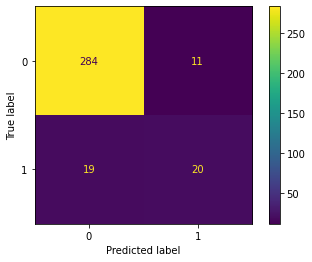

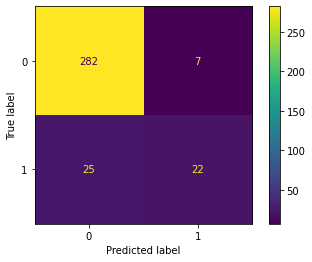

In [ ]:
logreg = LogisticRegression()
model = logreg.fit(X_train_RFE_final, y_train_RFE_final)
y_pred_val = logreg.predict(X_val_RFE_final)
print(classification_report(y_val_RFE_final, y_pred_val))
cfm = confusion_matrix(y_val_RFE_final, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=logreg.classes_)
disp.plot()
y_pred_test = logreg.predict(X_test_RFE_final)
print(classification_report(y_test_RFE_final, y_pred_test))
cfm = confusion_matrix(y_test_RFE_final, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=logreg.classes_)
disp.plot()

In [ ]:
d = {'coefficient': model.coef_.T}
coefs= model.coef_.T

df_coef = pd.DataFrame(data=model.coef_.T, index = X_test_RFE_final.columns, columns=["coefficent"])

df_coef.sort_values(by='coefficent', ascending=False)


,coefficent
Marital_Status_Single,1.016258
Marital_Status_Divorced,0.988886
Time_delta,0.861128
Education_PhD,0.727132
CmpTotal_mean_5,0.471585
CmpTotal_mean_4,0.468861
MntMeatProducts,0.386474
AcceptedCmp5,0.280644
NumWebPurchases,0.221765
MntFruits,0.161983


Проверить коэф модели.

Бэйзлайн - как будто бы все приняли участие в акции.

Деление на тест, трейн и вал по айди.

В качестве ключевой метрики выбираем recall - нам важно обнаружить максимум людей, которые хотели бы участвовать в акции.

Baseline.

              precision    recall  f1-score   support

           0       0.00      1.00      0.01         1
           1       1.00      0.09      0.16       335

    accuracy                           0.09       336
   macro avg       0.50      0.54      0.08       336
weighted avg       1.00      0.09      0.16       336



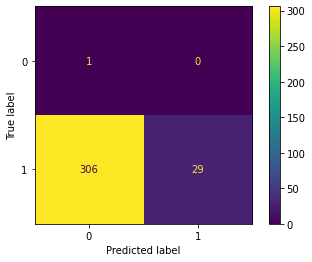

In [ ]:
y_pred_test = logreg.predict(X_test_RFE_final)
print(classification_report(y_base, y_pred_test))
cfm = confusion_matrix(y_base, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=logreg.classes_)
disp.plot()

catboost

In [ ]:
cat_features_mask = (X_train.dtypes == "object").values
cat_features_mask_val = (X_val.dtypes == "object").values
cat_features_mask_test = (X_test.dtypes == "object").values

In [ ]:
X_train_cat = X_train[X_train.columns[~cat_features_mask]]
X_val_cat = X_val[X_val.columns[~cat_features_mask]]
X_test_cat = X_test[X_test.columns[~cat_features_mask_test]]

Задаем параметры catboost, оптимизированные с помощью gridsearch (код в конце ноутбука, он очень долго выполняется, поэтому вынесен отдельно).

In [ ]:
dfc= X_train_cat.copy()
dfc['Income'].fillna(0.0, inplace = True)
dff = X_train[X_train.columns[cat_features_mask]].copy()
scaler = StandardScaler()
scalerModel = scaler.fit(dfc)
scaledData = scalerModel.transform(dfc)
dfs = pd.DataFrame(scaledData, columns=dfc.columns)
X_train_cat_mod = dfs.join(dff)

In [ ]:
dfc= X_val_cat.copy()
dfc['Income'].fillna(0.0, inplace = True)
dff = X_train[X_train.columns[cat_features_mask]].copy()
scaler = StandardScaler()
scalerModel = scaler.fit(dfc)
scaledData = scalerModel.transform(dfc)
dfs = pd.DataFrame(scaledData, columns=dfc.columns)
X_val_cat_mod = dfs.join(dff)

In [ ]:
dfc= X_test_cat.copy()
dfc['Income'].fillna(0.0, inplace = True)
dff = X_train[X_train.columns[cat_features_mask]].copy()
scaler = StandardScaler()
scalerModel = scaler.fit(dfc)
scaledData = scalerModel.transform(dfc)
dfs = pd.DataFrame(scaledData, columns=dfc.columns)
X_test_cat_mod = dfs.join(dff)

In [ ]:
cat_features = X_train_cat_mod.columns[np.where(X_train_cat_mod.dtypes != float)[0]].values.tolist()

In [ ]:
X_train_cat_mod[cat_features]=X_train_cat_mod[cat_features].astype(str)
X_val_cat_mod[cat_features]=X_val_cat_mod[cat_features].astype(str)
X_test_cat_mod[cat_features]=X_test_cat_mod[cat_features].astype(str)

In [ ]:
cat_features

['Education', 'Marital_Status', 'Country']

In [ ]:
cb_model = cb.CatBoostClassifier(
    eval_metric='Recall',
    depth = 4,
    l2_leaf_reg = 10,
    learning_rate = 0.25,
    iterations = 100)

In [ ]:
cb_model.fit(X_train_cat_mod, y_train, cat_features=cat_features, verbose = False)

In [ ]:
cb_train_pred = cb_model.predict(X_train_cat_mod)

Предсказание для валидационной выборки и эффективность модели.

In [ ]:
cb_val_pred = cb_model.predict(X_val_cat_mod)
cb_test_pred = cb_model.predict(X_test_cat_mod)

In [ ]:
#from catboost import CatBoostClassifier
#model = CatBoostClassifier()
#grid = {'iterations':[100,250,500],
#       'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25],
#       'depth': [2, 4, 6, 8],
#       'l2_leaf_reg': [5, 10, 15]}

#grid_search_result = model.grid_search(grid,
#                                  X=X_val_cat,
#                                  y=y_val,
#                                  plot=True,
#                                  verbose = False)

In [ ]:
#grid_search_result['params']

Посмотрим на ключевые признаки изменения количества продаж, исходя из нашей модели. Воспользуемся для этого библиотекой shap. Из графика видно, что наибольшее значение имеет цена товара, средние продажи, и средние продажи за месяц.

In [ ]:
explainer = shap.TreeExplainer(cb_model)
shap_values = explainer.shap_values(X_val_cat_mod)

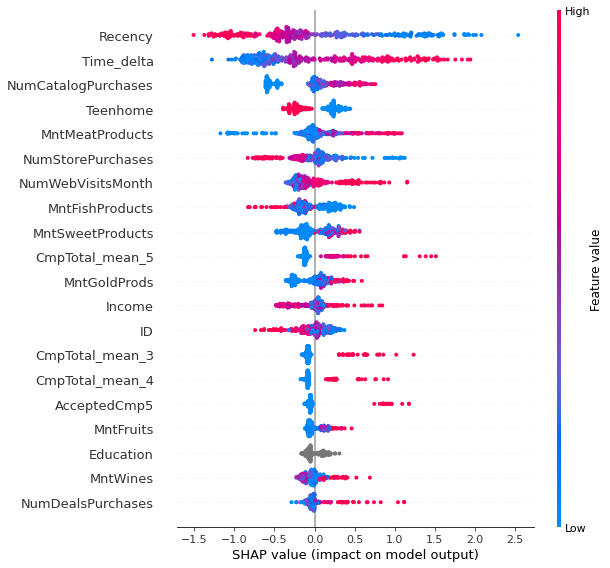

In [ ]:
shap.summary_plot(shap_values, X_val_cat_mod)

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       295
           1       0.61      0.49      0.54        39

    accuracy                           0.90       334
   macro avg       0.77      0.72      0.74       334
weighted avg       0.90      0.90      0.90       334



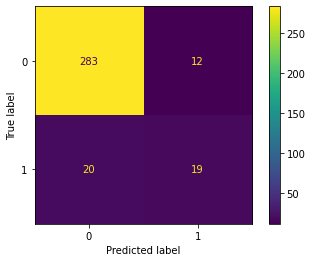

In [ ]:
#print(classification_report(y_train, cb_train_pred))
print(classification_report(y_val, cb_val_pred))
cfm = confusion_matrix(y_val, cb_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=logreg.classes_)
disp.plot()


              precision    recall  f1-score   support

           0       0.91      0.97      0.94       289
           1       0.69      0.43      0.53        47

    accuracy                           0.89       336
   macro avg       0.80      0.70      0.73       336
weighted avg       0.88      0.89      0.88       336



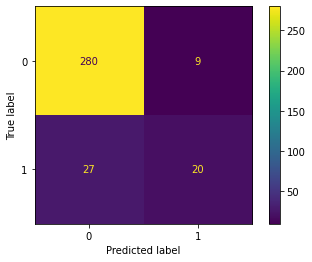

In [ ]:
#print(classification_report(y_train, cb_train_pred))
print(classification_report(y_test, cb_test_pred))
cfm = confusion_matrix(y_test, cb_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=logreg.classes_)
disp.plot()

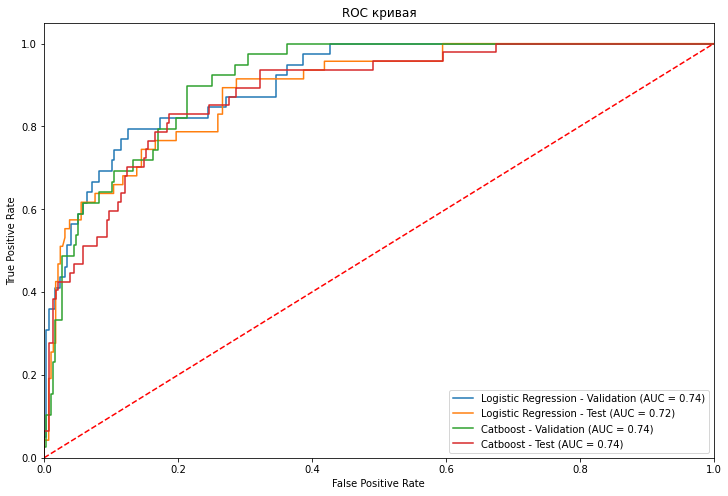

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test_RFE_final, logreg.predict(X_test_RFE_final))
fpr, tpr, thresholds = roc_curve(y_test_RFE_final, logreg.predict_proba(X_test_RFE_final)[:,1])
logit_roc_auc_val = roc_auc_score(y_val_RFE_final, logreg.predict(X_val_RFE_final))
fpr_val, tpr_val, thresholds_val = roc_curve(y_val_RFE_final, logreg.predict_proba(X_val_RFE_final)[:,1])
#logit_roc_auc_base = roc_auc_score(y_base, logreg.predict(X_test_RFE_final))
#fpr_base, tpr_base, thresholds_base = roc_curve(y_base, logreg.predict_proba(X_test_RFE_final)[:,1])
fpr_cb, tpr_cb, thresholds_cb = roc_curve(y_test, cb_model.predict_proba(X_test_cat_mod)[:,1], pos_label=1)
fpr_cb_val, tpr_cb_val, thresholds_cb_val = roc_curve(y_val, cb_model.predict_proba(X_val_cat_mod)[:,1], pos_label=1)
plt.figure(figsize=(12, 8))
#plt.plot(fpr_base, tpr_base, label='Logistic Regression - Baseline (AUC = %0.2f)' % logit_roc_auc_base)
plt.plot(fpr_val, tpr_val, label='Logistic Regression - Validation (AUC = %0.2f)' % logit_roc_auc_val)
plt.plot(fpr, tpr, label='Logistic Regression - Test (AUC = %0.2f)' % logit_roc_auc)
plt.plot(fpr_cb_val, tpr_cb_val, label='Catboost - Validation (AUC = %0.2f)' % logit_roc_auc_val)
plt.plot(fpr_cb, tpr_cb, label='Catboost - Test (AUC = %0.2f)' % logit_roc_auc_val)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()